# 🤖 Modeling et Évaluation
## Santander Customer Transaction Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)
print('✅ Bibliothèques importées')

✅ Bibliothèques importées


## 1️⃣ Chargement et préparation

In [2]:
train = pd.read_csv('../data/train.csv')
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Train: {X_train.shape}, Val: {X_val.shape}')

Train: (160000, 200), Val: (40000, 200)


## 2️⃣ Logistic Regression

In [3]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
y_proba_lr = lr.predict_proba(X_val)[:, 1]

print(f'LR - ROC-AUC: {roc_auc_score(y_val, y_proba_lr):.4f}')

LR - ROC-AUC: 0.8583


## 3️⃣ Random Forest

In [4]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]

print(f'RF - ROC-AUC: {roc_auc_score(y_val, y_proba_rf):.4f}')

RF - ROC-AUC: 0.7913


## 4️⃣ XGBoost

In [5]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
y_proba_xgb = xgb.predict_proba(X_val)[:, 1]

print(f'XGB - ROC-AUC: {roc_auc_score(y_val, y_proba_xgb):.4f}')

XGB - ROC-AUC: 0.8499


## 5️⃣ LightGBM

In [6]:
lgbm = LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, class_weight='balanced', random_state=42, verbose=-1)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)
y_proba_lgbm = lgbm.predict_proba(X_val)[:, 1]

print(f'LGBM - ROC-AUC: {roc_auc_score(y_val, y_proba_lgbm):.4f}')

LGBM - ROC-AUC: 0.8551


## 6️⃣ Comparaison

In [7]:
results = pd.DataFrame({
    'Model': ['LR', 'RF', 'XGB', 'LGBM'],
    'ROC-AUC': [
        roc_auc_score(y_val, y_proba_lr),
        roc_auc_score(y_val, y_proba_rf),
        roc_auc_score(y_val, y_proba_xgb),
        roc_auc_score(y_val, y_proba_lgbm)
    ]
})

print(results)
best_idx = results['ROC-AUC'].idxmax()
best_model_name = results.loc[best_idx, 'Model']
print(f'\n🏆 Meilleur modèle: {best_model_name}')

  Model   ROC-AUC
0    LR  0.858279
1    RF  0.791294
2   XGB  0.849894
3  LGBM  0.855090

🏆 Meilleur modèle: LR


## 7️⃣ Sauvegarde du meilleur modèle

In [8]:
models = {'LR': lr, 'RF': rf, 'XGB': xgb, 'LGBM': lgbm}
best_model = models[best_model_name]
joblib.dump(best_model, '../models/best_model.pkl')
print(f'✅ Modèle {best_model_name} sauvegardé')

✅ Modèle LR sauvegardé


## 8️⃣ Courbes ROC

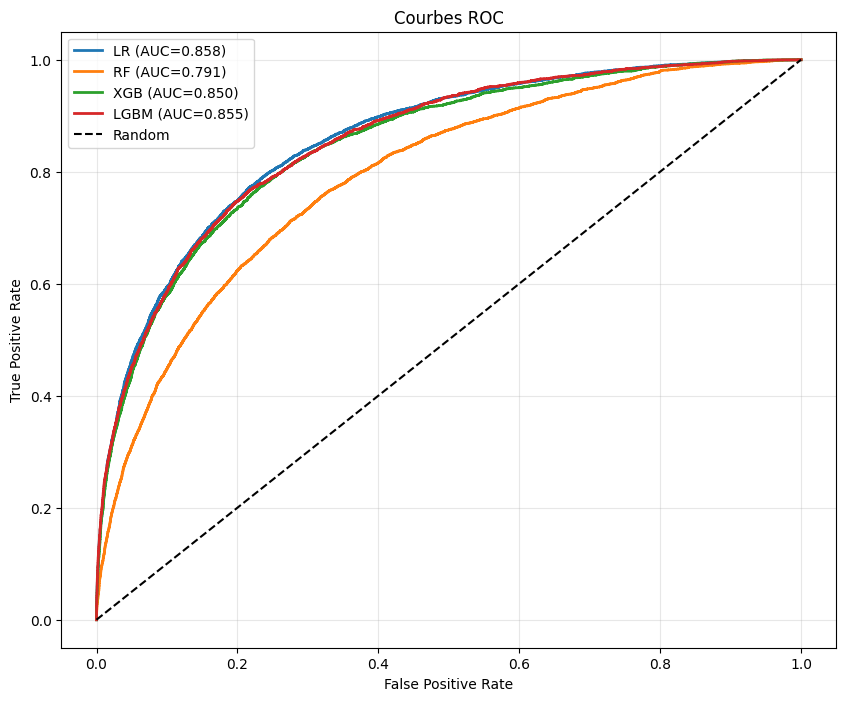

In [9]:
plt.figure(figsize=(10, 8))

for name, y_proba in [('LR', y_proba_lr), ('RF', y_proba_rf), ('XGB', y_proba_xgb), ('LGBM', y_proba_lgbm)]:
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc = roc_auc_score(y_val, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## ✅ Modeling terminé !

Prochaine étape: API et Frontend